BEGIN
3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
<xarray.DataArray (time: 7305, lat: 13, lon: 144)> Size: 109MB
array([[[ 0.50620516,  0.25823439, -0.01331365, ...,  1.05476238,
          0.90428457,  0.72231823],
        [-0.47468069, -0.8772616 , -1.27752834, ...,  0.4110752 ,
          0.19203081, -0.10855861],
        [-1.50637906, -2.04272434, -2.52598787, ..., -0.05370464,
         -0.47072055, -0.96700713],
        ...,
        [ 0.99712035,  1.34915968,  1.75283663, ...,  0.35934027,
          0.5064613 ,  0.71522691],
        [-0.29115545, -0.08614146,  0.20646672, ..., -0.39838747,
         -0.43420711, -0.40456294],
        [-1.4038843 , -1.13766711, -0.80232037, ..., -1.61727216,
         -1.65140309, -1.5795507 ]],

       [[ 0.26266955,  0.02975292, -0.23308   , ...,  0.70950558,
          0.60140783,  0.45417943],
        [-0.82267832, -1.20656703, -1.55254271, ...,  0.1247237 ,
         -0.12246631, -0.44777881],
       

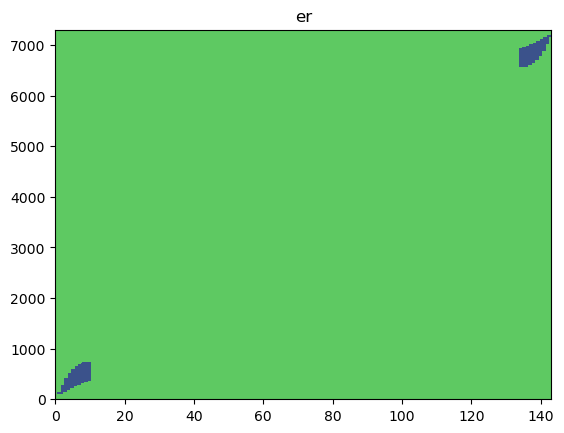

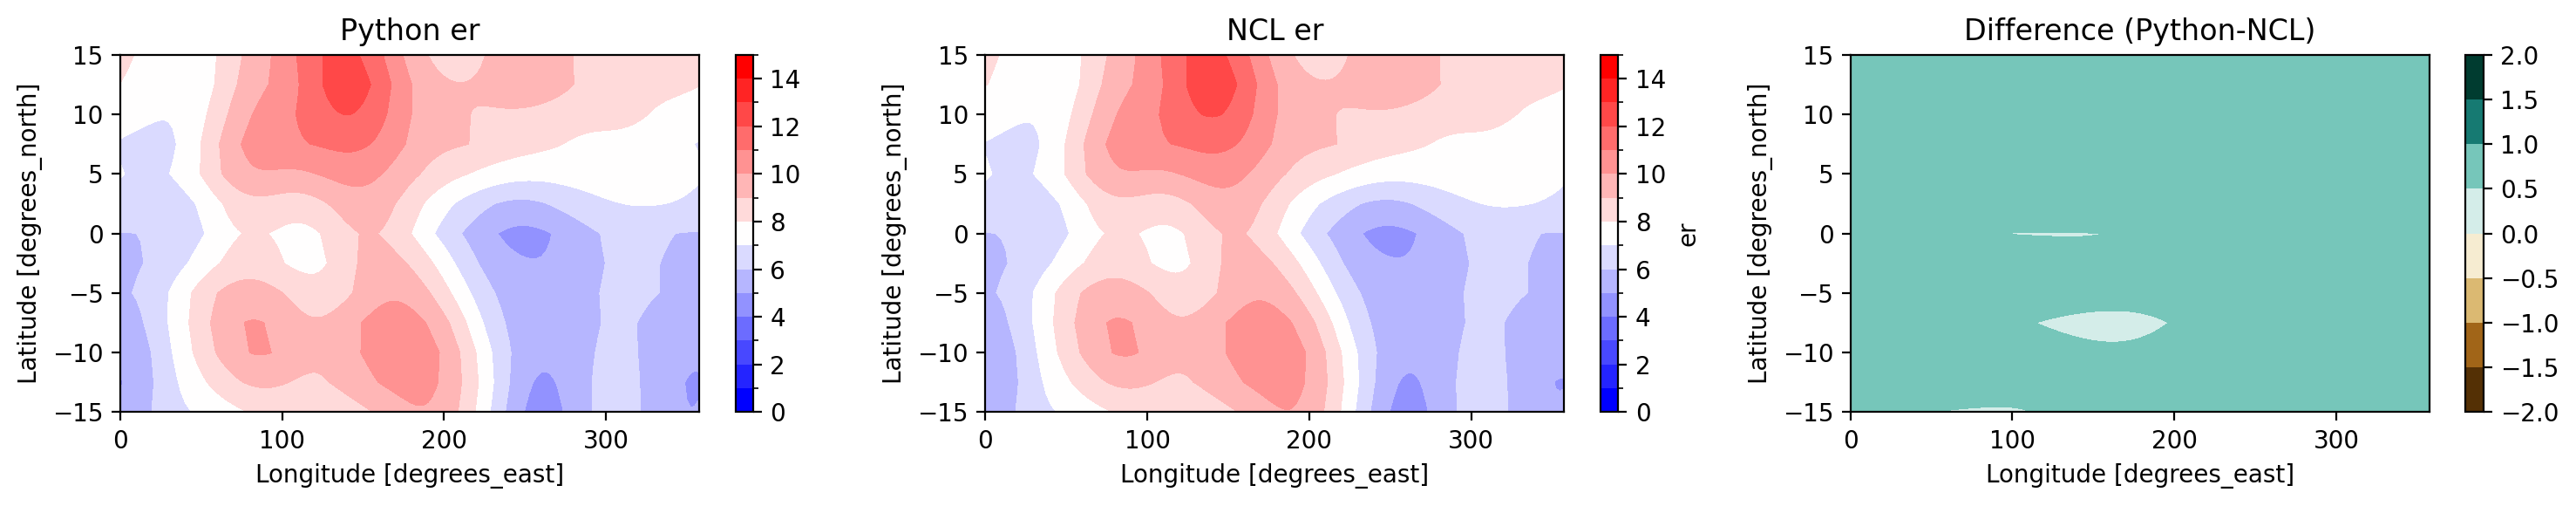

DONE!
Runtime:     25.0 seconds.


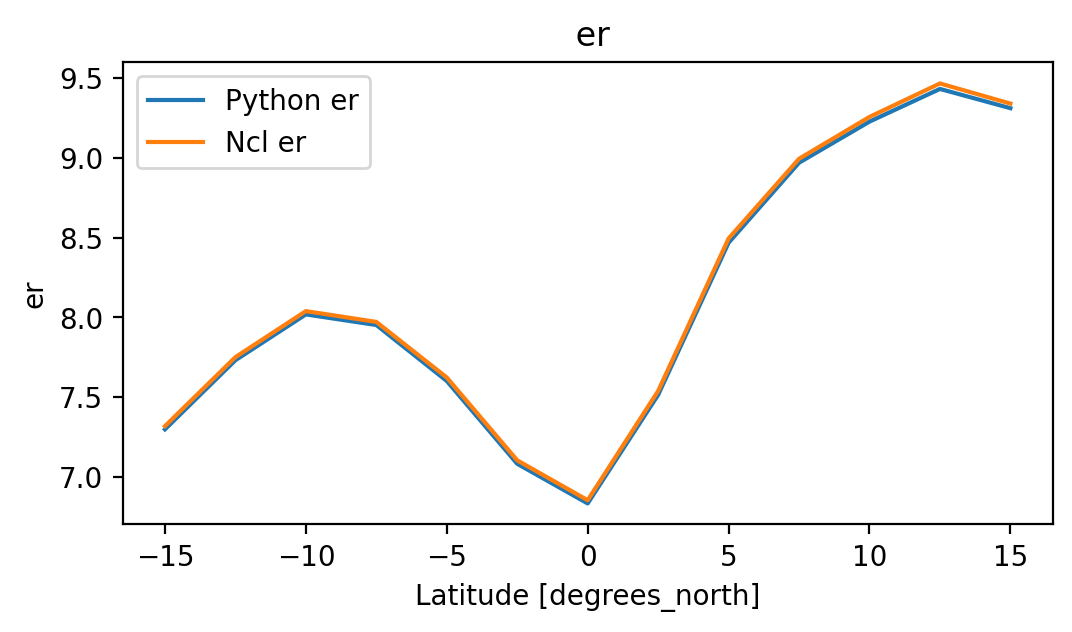

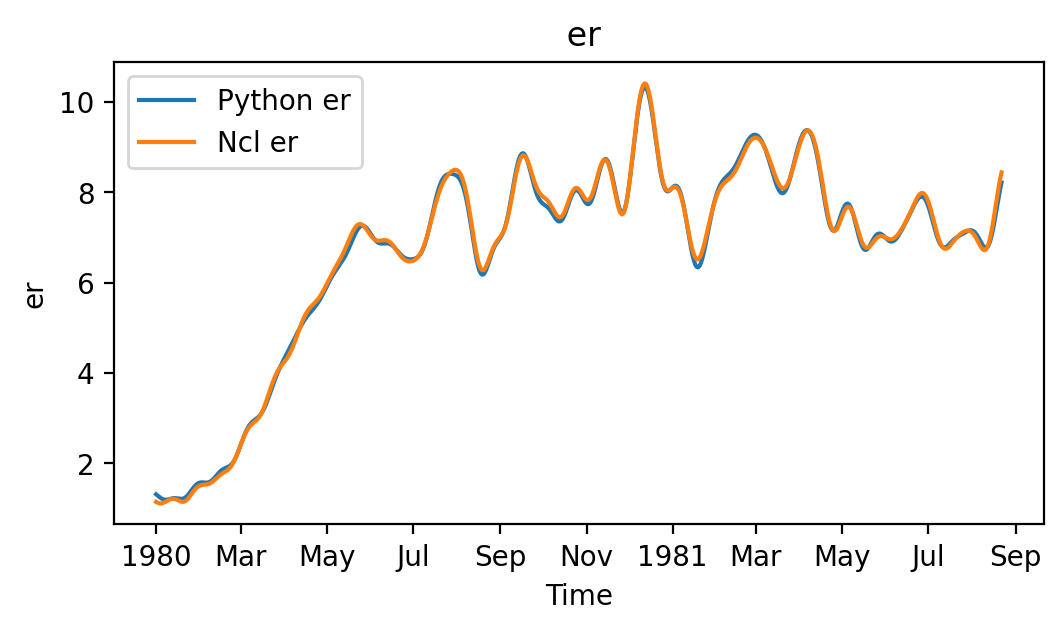

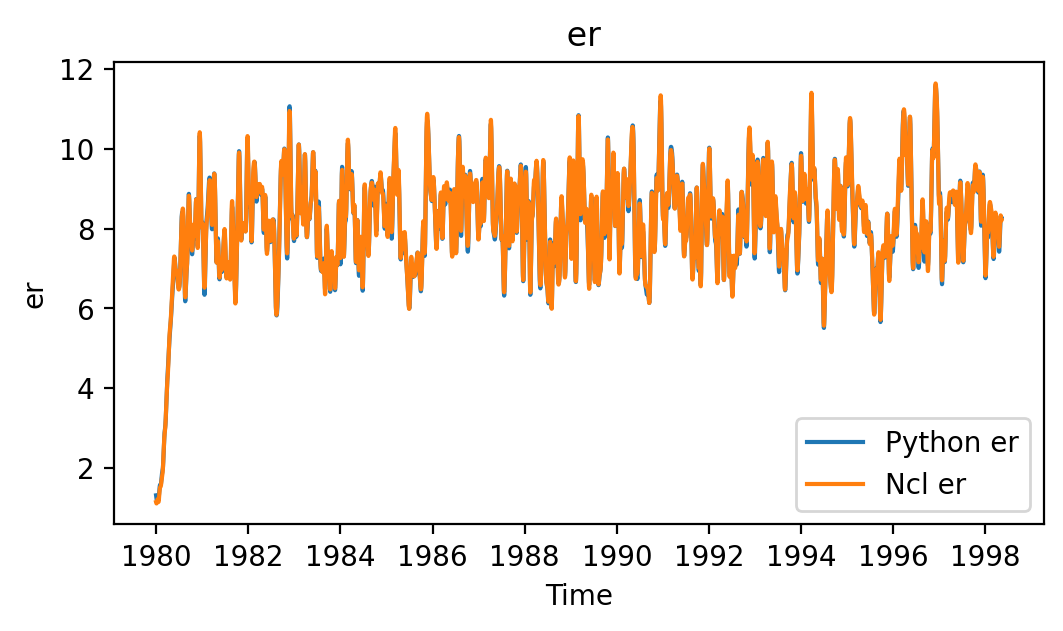

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar  3 15:25:08 2025

@author: xpji

This script is used to filter waves in the OLR data using dask for parallel processing.
The script is based on the NCL example: https://www.ncl.ucar.edu/Document/Functions/User_contributed/kf_filter.shtml
The script is tested on the OLR data from the NCL example and the results are validated against the NCL output.

"""

import time
import sys
import numpy as np
from scipy import signal
import xarray as xr
import matplotlib.pyplot as plt
import dask.array as da



class WaveFilter:
    def __init__(self, path, time_range, lat_range, wave_name,units, n_workers=4):
        self.path = path
        self.time_range = time_range
        self.lat_range = lat_range
        self.wave_name = wave_name
        self.n_workers = n_workers
        self.ds = xr.open_dataset(path,chunks={'time': 'auto'})  # 使用 dask 分块加载
        self.data = None
        self.units = units
        self.filtered_data = None
        self.fftdata = None
    def print_diagnostic_info(self, variable, name):
        """打印变量的诊断信息"""
        try:
            print(f"\n=== {name} Information ===")
            print(f"Type: {type(variable)}")
            print(f"Shape: {variable.shape}")
            if isinstance(variable, (da.Array, np.ndarray, xr.DataArray)):
                print(f"Data type: {variable.dtype}")
            if isinstance(variable, da.Array):
                print(f"Chunks: {variable.chunks}")
            print(f"First few values: {variable[:5]}")  # 只打印前5个值
            print("========================\n")
        except Exception as e:
            print(f"Error printing info for {name}: {e}")
            
    def load_data(self):
        """Load and preprocess data."""
        self.data = self.ds.olr.sel(
            time=slice(*self.time_range),
            lat=slice(*self.lat_range)
        ).sortby('lat').transpose('time', 'lat', 'lon')
        
        # print(f"Data chunks before rechunk: {self.data.chunks}")
        self.data = self.data.chunk({'time': -1})
        # print(f"Data chunks after rechunk: {self.data.chunks}")
        # 计算日异常值
        # self.anomaly = self.data.groupby('time.dayofyear') - self.data.groupby('time.dayofyear').mean()
        
    def detrend_data(self):
        """Detrend the data using dask for parallel processing."""
        ntim, nlat, nlon = self.data.shape
        spd = 1 # obs_per_day, if one day have four times sample ,then spd=4
       
        data_rechunked = self.data.data.rechunk({0: -1})
        if ntim >  365*spd/3:

            # 进行并行 FFT
            rf = da.fft.rfft(data_rechunked, axis=0)
            freq = da.fft.rfftfreq(ntim * spd, d=1. / float(spd))
            rf[(freq <= 3. / 365) & (freq >= 1. / 365), :, :] = 0.0
            datain = da.fft.irfft(rf, axis=0, n=ntim)
 
        # 使用 dask 并行去趋势
        self.detrend = da.apply_along_axis(signal.detrend, 0, datain)
    
        window = signal.windows.tukey(7305,0.05,True)
        
        self.detrend = self.detrend * window[:, np.newaxis, np.newaxis]   
        
    def fft_transform(self):
        """Perform 2D FFT on the detrended data using dask."""
        
        # data.shape[2] is the length of lon
        self.wavenumber = -da.fft.fftfreq(self.data.shape[2]) * self.data.shape[2]   # shape: (lon,)
        self.frequency = da.fft.fftfreq(self.data.shape[0], d=1. / float(1))    # shape: (time,)
        # print("\nFrequency values:")
        # print(self.frequency.compute())
        # print("\nFirst 10 frequency values:")
        # print(self.frequency[:10].compute())
        # print("\nWavenumber values:")
        # print(self.wavenumber.compute())
        self.knum_ori, self.freq_ori = da.meshgrid(self.wavenumber, self.frequency)   # shape: (time, lon)
        self.knum = self.knum_ori.copy()
        # print(self.knum_ori.compute().shape)
        self.knum = da.where(self.freq_ori < 0, -self.knum_ori, self.knum_ori)   # shape: (time, lon)
        plt.title(f'{wave_name}')
        
        
        self.freq = da.abs(self.freq_ori)    # shape: (time, lon)
    
    def apply_filter(self):
        """Apply filter based on wave type."""
        if self.wave_name.lower() == "kelvin":
            self.tMin, self.tMax = 3, 20
            self.kmin, self.kmax = 2, 14
            self.hmin, self.hmax = 8, 90
        elif self.wave_name.lower() == "er":
            self.tMin, self.tMax = 9, 72
            self.kmin, self.kmax = -10, -1
            self.hmin, self.hmax = 8, 90
        
        
        
        self.fmin, self.fmax = 1 / self.tMax, 1 / self.tMin
        self.mask =  da.zeros((self.data.shape[0], self.data.shape[2]), dtype=bool)

     
        
        if self.kmin is not None:
            self.mask = self.mask | (self.knum < self.kmin)
        if self.kmax is not None:
            self.mask = self.mask | (self.kmax < self.knum)

        if self.fmin is not None:
            self.mask = self.mask | (self.freq < self.fmin)
        if self.fmax is not None:
            self.mask = self.mask | (self.fmax < self.freq)

        if self.wave_name.lower() == 'kelvin':
            self.apply_wave_filter(self.wave_name)
        elif self.wave_name.lower() == 'er':
            self.apply_wave_filter(self.wave_name)
            
        plt.contourf(self.mask[:,:].compute())
        self.fftdata = da.fft.fft2(self.detrend, axes=(0, 2)) # shape: (time, lat, lon)
        self.mask = da.repeat(self.mask[:, np.newaxis, :], self.data.shape[1], axis=1)
     
        # self.fftdata[self.mask] = 0.0
        self.fftdata = da.where(self.mask, 0.0, self.fftdata)
        
    def apply_wave_filter(self,wave_name):
        """Apply Kelvin wave filter."""
        g = 9.8
        beta = 2.28e-11
        a = 6.37e6
        n = 1 
        if self.wave_name.lower() == "kelvin":
            
            if self.hmin is not None:
                c = da.sqrt(g * self.hmin)
                omega = 2. * np.pi * self.freq / 24. / 3600. / da.sqrt(beta * c)
                k = self.knum / a * da.sqrt(c / beta)
                self.mask = self.mask | (omega - k < 0)
            if self.hmax is not None:
                c = da.sqrt(g * self.hmax)
                omega = 2. * np.pi * self.freq / 24. / 3600. / da.sqrt(beta * c)
                k = self.knum / a * da.sqrt(c / beta)
                self.mask = self.mask | (omega - k > 0)
    
        if self.wave_name.lower() == "er":
    
            if self.hmin is not None:
                c = da.sqrt(g * self.hmin)
                omega = 2. * np.pi * self.freq / 24. / 3600. / da.sqrt(beta * c)
                k = self.knum / a * da.sqrt(c / beta)
                self.mask = self.mask | (omega * (k ** 2 + (2 * n + 1)) + k < 0)
            if self.hmax is not None:
                c = da.sqrt(g * self.hmax)
                omega = 2. * np.pi * self.freq / 24. / 3600. / da.sqrt(beta * c)
                k = self.knum / a * da.sqrt(c / beta)
                self.mask = self.mask | (omega * (k ** 2 + (2 * n + 1)) + k > 0)
         # if wavename.lower() == "er":
         
         
         
         
    def inverse_fft(self):
        """Perform inverse FFT to get filtered data."""
        self.filtered_data = da.fft.ifft2(self.fftdata, axes=(0, 2)).real

    def create_output(self):
        """Create xarray DataArray for filtered data."""
        self.wave_data = xr.DataArray(self.filtered_data.compute(),  # 将 dask 数组转换为 numpy 数组
                                      coords = {'time': self.data.time,
                                                'lat': self.data.lat,
                                                'lon': self.data.lon},
                                          
                                      dims=['time', 'lat', 'lon'])
        self.wave_data.attrs.update({
            'long_name': self.wave_name,
            'min_equiv_depth': self.hmin,
            'max_equiv_depth': self.hmax,
            'min_wavenumber': self.kmin,
            'max_wavenumber': self.kmax,
            'min_period': self.tMin,
            'max_period': self.tMax,
            'min_frequency': self.fmin,
            'max_frequency': self.fmax,
            
            'units': self.units,

        })
        
        print(self.wave_data.compute())
        
    def validate(self, ncl_output_path):
        """Validate results against NCL output."""
        ncl_wave = xr.open_dataset(ncl_output_path)[self.wave_name]
        diff = self.wave_data - ncl_wave

        plt.figure(dpi=200, figsize=(15, 3))

        plt.subplot(131)
        self.wave_data.std('time').plot.contourf(levels=np.linspace(0, 15, 16), cmap='bwr')
        plt.title(f'Python {self.wave_name}')

        plt.subplot(132)
        ncl_wave.std('time').plot.contourf(levels=np.linspace(0, 15, 16), cmap='bwr')
        plt.title(f'NCL {self.wave_name}')

        plt.subplot(133)
        diff.std('time').plot.contourf(cmap='BrBG', levels=np.linspace(-2, 2, 9))
        plt.title('Difference (Python-NCL)')

        plt.tight_layout()
        plt.show() 
        
        
        
        plt.figure(dpi=200,figsize=(6,3))  
        self.wave_data.std(['time','lon']).plot(label=f'Python {self.wave_name}')
        ncl_wave.std(['time','lon']).plot(label=f'Ncl {wave_name}')
        plt.title(f' {wave_name}')
        plt.legend()

        plt.figure(dpi=200,figsize=(6,3)) 
        self.wave_data[0:600].std(['lat','lon']).plot(label=f'Python {wave_name}')
        ncl_wave[0:600].std(['lat','lon']).plot(label=f'Ncl {wave_name}')
        plt.title(f' {wave_name}') 
        plt.legend()
        
        plt.figure(dpi=200,figsize=(6,3)) 
        self.wave_data[:-600].std(['lat','lon']).plot(label=f'Python {wave_name}')
        ncl_wave[:-600].std(['lat','lon']).plot(label=f'Ncl {wave_name}')
        plt.title(f' {wave_name}') 
        plt.legend()
        
start=time.time()

print("BEGIN")
print(sys.version)
# Example usage
path = r'./olr.day.mean.nc'
time_range = ('1980-01-01', '1999-12-31')
lat_range = [15, -15]

wave_name = 'er'

wave_filter = WaveFilter(path, time_range, lat_range, wave_name, units='W/m2', n_workers=4)
wave_filter.load_data()
wave_filter.detrend_data()


wave_filter.fft_transform()
wave_filter.apply_filter()
wave_filter.inverse_fft()
wave_filter.create_output()
ncl_output_path = "./olr." + wave_name + ".15_wm_2_14_smooth.nc"
wave_filter.validate(ncl_output_path)
print("DONE!")
end=time.time()
print ("Runtime: %8.1f seconds." % (end-start)) 

# %%
